# Laugh detector

In [1]:
%%capture

%matplotlib inline

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from IPython.display import SVG
from keras.utils import get_file
from keras.utils import Sequence
from sklearn.metrics import roc_curve, auc
from features.sampler import SSPNetSampler
from keras.utils.vis_utils import model_to_dot
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Dense, TimeDistributed, concatenate

## Data

In [2]:
SSPNET_FNAME = 'vocalizationcorpus.zip'
SSPNET_NOISY_FNAME = 'vocalizationcorpus_noisy.zip'
SSPNET_URL = f'http://www.dcs.gla.ac.uk/~vincia/datavocalizations/{SSPNET_FNAME}'
SSPNET_NOISY_URL = None
IS_NOISY = False
SSPNET_SAMPLE_PATH = 'sspnet_{}sample.hdf5'.format('noisy_' if IS_NOISY else '')
RENEW_PREPROCESSING = False

In [3]:
def prepare_data(noisy):
    fname, url = (SSPNET_FNAME, SSPNET_URL) if not noisy else (SSPNET_NOISY_FNAME, SSPNET_NOISY_URL)
    data_path = os.path.abspath(os.path.join(get_file(fname, url, extract=True), os.pardir))
    sample_wav = random.choice(os.listdir(os.path.join(data_path, 'data')))
    sample_wav_path = os.path.join(data_path, f'data/{sample_wav}')
    return data_path, sample_wav_path

In [4]:
%time data_path, sample_wav_path = prepare_data(IS_NOISY)
data_path, sample_wav_path

CPU times: user 11 s, sys: 2.29 s, total: 13.3 s
Wall time: 19 s


('/home/s_belyaev/.keras/datasets',
 '/home/s_belyaev/.keras/datasets/data/S1589.wav')

In [5]:
sampler = SSPNetSampler(data_path)
if os.path.exists(SSPNET_SAMPLE_PATH) and not RENEW_PREPROCESSING:
    print("Loading data...")
    df = pd.read_hdf(SSPNET_SAMPLE_PATH)
else:
    print("Preprocessing data... This takes quite some time.")
    df = sampler.sample()
    df.to_hdf(SSPNET_SAMPLE_PATH, 'df', mode='w', format='t', complevel=9)
df.shape

Loading data...


(287175, 149)

In [6]:
df.head()

mfcc_0      mfcc_1     mfcc_2     mfcc_3     mfcc_4  \
sname frame                                                            
S0001 0     -373.153344   95.437358 -36.818135  79.920083 -54.271679   
      1     -368.873474   91.749633 -39.974858  86.175749 -54.903850   
      2     -345.033844   82.671671 -50.393587  87.817926 -28.268000   
      3     -363.373324  102.701456 -55.447781  84.630006 -45.017445   
      4     -354.578753   93.754298 -51.155186  77.997912 -41.856521   

                mfcc_5     mfcc_6     mfcc_7    mfcc_8    mfcc_9  ...    \
sname frame                                                       ...     
S0001 0      55.084835 -20.286583   8.164827 -2.757196  5.251594  ...     
      1      51.001815 -15.739164  16.430699  0.200041  4.824776  ...     
      2      35.189449 -32.786128   8.540034  5.724057 -5.437554  ...     
      3      61.637147 -29.870310   4.005429 -3.113288  2.105346  ...     
      4      55.107681 -23.394692  11.669452  3.903726  0.010206  ...     

                fbank_119     fbank_120     fbank_121     fbank_122  \
sname frame                                                           
S0001 0      7.278168e-07  6.589588e-07  6.040244e-07  5.593640e-07   
      1      1.367360e-06  1.253789e-06  1.164664e-06  1.092242e-06   
      2      8.951212e-07  8.683028e-07  8.403387e-07  8.127290e-07   
      3      1.137379e-07  1.179747e-07  1.201544e-07  1.208756e-07   
      4      1.142249e-06  1.012612e-06  9.149614e-07  8.388911e-07   

                fbank_123     fbank_124     fbank_125     fbank_126  \
sname frame                                                           
S0001 0      5.235364e-07  4.957071e-07  4.744663e-07  4.597197e-07   
      1      1.033866e-06  9.883410e-07  9.533186e-07  9.289612e-07   
      2      7.875098e-07  7.662990e-07  7.488896e-07  7.364185e-07   
      3      1.207444e-07  1.202646e-07  1.195959e-07  1.190428e-07   
      4      7.796813e-07  7.346294e-07  7.007919e-07  6.775230e-07   

                fbank_127  laugh  
sname frame                       
S0001 0      4.506246e-07      0  
      1      9.137928e-07      0  
      2      7.283180e-07      0  
      3      1.185911e-07      0  
      4      6.632934e-07      0  

[5 rows x 149 columns]

In [7]:
N_SNAMES = len(df.index.get_level_values(0).unique())
N_FRAMES = len(df.index.get_level_values(1).unique())
N_MFCC_FEATURES = df.columns.str.contains('mfcc').sum()
N_FBANK_FEATURES = df.columns.str.contains('fbank').sum()

## TT generator

In [8]:
def mi_tt_split(df):
    snames_train, snames_test = train_test_split(df.index.get_level_values(0).unique(), test_size=0.2)
    return df.loc[snames_train.tolist()], df.loc[snames_test.tolist()]


def np_prepare(df):
    n_snames = len(df.index.get_level_values(0).unique())
    X = df.drop('laugh', axis=1).as_matrix().reshape((n_snames, N_FRAMES, N_MFCC_FEATURES + N_FBANK_FEATURES))
    X_mfcc, X_fbank = X[:, :, :N_MFCC_FEATURES], X[:, :, N_MFCC_FEATURES:]
    y = np.expand_dims(df.laugh.as_matrix().reshape((n_snames, N_FRAMES)), 2)
    return {'mfcc_input': X_mfcc, 'fbank_input': X_fbank}, {'mfcc_output': y, 'all_output': y}

In [9]:
df_train, df_test = mi_tt_split(df)
(X_train, y_train), (X_test, y_test) = np_prepare(df_train), np_prepare(df_test)
y_test = y_test['all_output']

## Model

In [10]:
BATCH_SIZE = 64
N_EPOCHS = 5
MODEL_PATH = 'model.hdf5'

In [11]:
# MFCC
mfcc_input = Input(shape=(N_FRAMES, N_MFCC_FEATURES), name='mfcc_input')
mfcc_lstm = LSTM(100, return_sequences=True)(mfcc_input)
mfcc_output = TimeDistributed(Dense(1, activation='sigmoid'), name='mfcc_output')(mfcc_lstm)

# FBANK
fbank_input = Input(shape=(N_FRAMES, N_FBANK_FEATURES), name='fbank_input')
fbank_lstm = LSTM(100, return_sequences=True)(fbank_input)
all_lstm = concatenate([mfcc_lstm, fbank_lstm])
all_output = TimeDistributed(Dense(1, activation='sigmoid'), name='all_output')(all_lstm)

# Model
model = Model(inputs=[mfcc_input, fbank_input], outputs=[mfcc_output, all_output])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'],
              loss_weights=[N_MFCC_FEATURES, N_FBANK_FEATURES + N_MFCC_FEATURES])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mfcc_input (InputLayer)         (None, 105, 20)      0                                            
__________________________________________________________________________________________________
fbank_input (InputLayer)        (None, 105, 128)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 105, 100)     48400       mfcc_input[0][0]                 
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 105, 100)     91600       fbank_input[0][0]                
__________________________________________________________________________________________________
concatenat

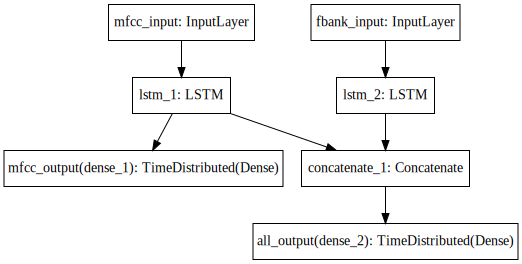

In [12]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [13]:
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_split=0.1);

Train on 1969 samples, validate on 219 samples
Epoch 1/5
1969/1969 [==============================] - 7s 3ms/step - loss: 34.5536 - mfcc_output_loss: 0.2777 - all_output_loss: 0.1959 - mfcc_output_binary_accuracy: 0.9252 - all_output_binary_accuracy: 0.9333 - val_loss: 29.3155 - val_mfcc_output_loss: 0.2001 - val_all_output_loss: 0.1710 - val_mfcc_output_binary_accuracy: 0.9524 - val_all_output_binary_accuracy: 0.9524
Epoch 2/5
1969/1969 [==============================] - 6s 3ms/step - loss: 21.4953 - mfcc_output_loss: 0.1469 - all_output_loss: 0.1254 - mfcc_output_binary_accuracy: 0.9658 - all_output_binary_accuracy: 0.9661 - val_loss: 27.2868 - val_mfcc_output_loss: 0.1847 - val_all_output_loss: 0.1594 - val_mfcc_output_binary_accuracy: 0.9524 - val_all_output_binary_accuracy: 0.9534
Epoch 3/5
1969/1969 [==============================] - 6s 3ms/step - loss: 20.1865 - mfcc_output_loss: 0.1364 - all_output_loss: 0.1180 - mfcc_output_binary_accuracy: 0.9658 - all_output_binary_accuracy:

In [14]:
model.save(MODEL_PATH)

## Plots

### `AU`c

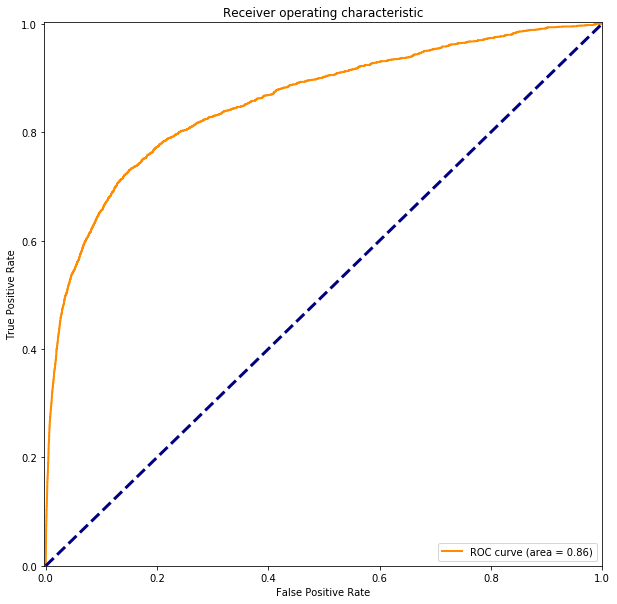

In [15]:
y_pred = model.predict(X_test)[1]

fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlim([-0.003, 1.0])
plt.ylim([0.0, 1.003])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right");

### Couple of samples

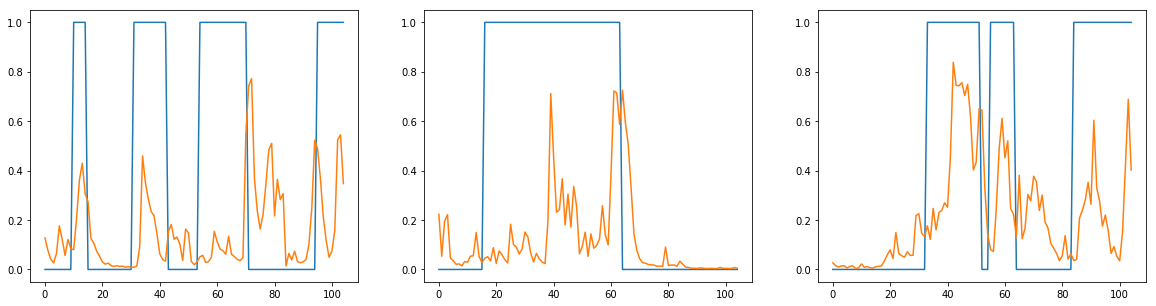

In [16]:
y_pred = model.predict(X_test)[1]
plt.figure(figsize=(20, 5))
for i, i_sname in enumerate(np.argsort(y_test[:, :, -1].mean(axis=1))[-3:]):
    plt.subplot(131 + i)
    plt.plot(np.arange(N_FRAMES), y_test[i_sname, :, -1], y_pred[i_sname, :, -1])

## Predictor

In [17]:
def predict(wav_path):
    sname, df = sampler.cook(wav_path)
    df.index = pd.MultiIndex.from_product([[sname], df.index], names=['sname', 'frame'])
    X, _ = np_prepare(df)
    y_pred = np.squeeze(model.predict(X)[1])
    mask = y_pred >= 0.5
    y_pred[mask], y_pred[np.invert(mask)] = 1, 0
    y_pred = y_pred.astype(int).tolist()
    return sampler.predicted_to_intervals(y_pred)

In [18]:
predict(sample_wav_path)

[]